# Episodic Semi-Gradient Sarsa RBF

Use a linear regresor with tiling to simplify the problem

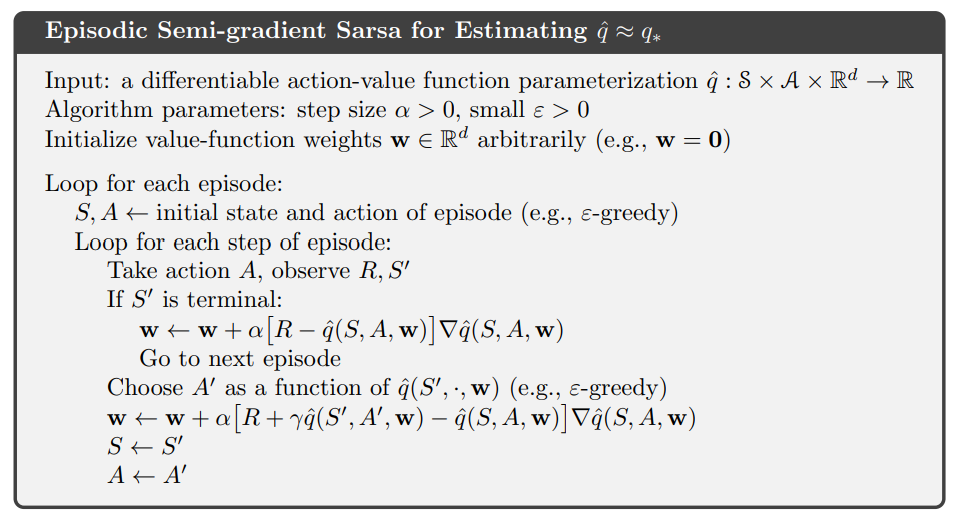

# Create Cart Pole Environment

In [1]:
import gym

In [2]:
env = gym.make('CartPole-v0')

# Get Env Details

<strong>FROM DOCUSTRING</strong>

```

    ### Description
    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
    ### Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
    **Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it
    ### Observation Space
    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | Cart Position         | -4.8                | 4.8               |
    | 1   | Cart Velocity         | -Inf                | Inf               |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
    | 3   | Pole Angular Velocity | -Inf                | Inf               |
    **Note:** While the ranges above denote the possible values for observation space of each element,
        it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates
       if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
       if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)
    ### Rewards
    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
    including the termination step, is allotted. The threshold for rewards is 475 for v1.
    ### Starting State
    All observations are assigned a uniformly random value in `(-0.05, 0.05)`
    ### Episode End
    The episode ends if any one of the following occurs:
    1. Termination: Pole Angle is greater than ±12°
    2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Truncation: Episode length is greater than 500 (200 for v0)
    ### Arguments

    gym.make('CartPole-v1')

    No additional arguments are currently supported.

    
```

In [3]:
print(env.action_space)

Discrete(2)


In [4]:
env.seed(42)
obs = env.reset()

print(obs)

obs = env.step(1)

print(obs)

obs = env.step(0)

print(obs)


[-0.01258566 -0.00156614  0.04207708 -0.00180545]
(array([-0.01261699,  0.19292789,  0.04204097, -0.28092127]), 1.0, False, {})
(array([-0.00875843, -0.00276775,  0.03642255,  0.02471922]), 1.0, False, {})


# Set Params

In [5]:
alpha = 0.10
epsilon = 0.90
gamma = .99

actions = [0,1]
count_actions = len(actions)


# Some Functions

In [6]:
import numpy as np

class sarsa_agent:
    """ 
    class to control the sarsa agent
    env is the ai gym environment used
    actions is the action space as a list
    q_hat is the function approximator used
    alpha is the learning rate
    epsilon is the proportion of times greedy actions are taken
    gamma is the discount factor
    num_ep is the number of episodes to use
    
    """
    def __init__(self, env, actions, q_hat, epsilon, gamma, num_ep, alpha):
        self.env = env
        self.actions = actions
        self.q_hat = q_hat
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_ep = num_ep   
        self.alpha = alpha
        self.episode_reward_tracking = []

    def policy(self, state, train):
        """
        select action to take

        """
        #print(state)
        #print([self.q_hat.predict(state, act) for act in self.actions])
        if train:
            if np.random.rand() < self.epsilon:
                #get max action
                action = np.argmax([self.q_hat.predict(state, act) for act in self.actions])
            else:
                #select non max action
                action = np.random.choice(self.actions)
        else:
            action = np.argmax([self.q_hat.predict(state, act) for act in self.actions])
        return action

    def run_episodes(self, train = 1):
        """
        run thru num_episodes to improve q_hat

        """
        for i in range(self.num_ep):
            
                        
            #early exit check (once model converges we dont want to update any more
            if len(self.episode_reward_tracking) >= 20:
                if np.mean(self.episode_reward_tracking[-20:]) >= 199:
                    print("convergence attained, early exit")
                    print("convergence attained with ", i, " episodes")
                    print("average reward over last 20 runs", np.mean(self.episode_reward_tracking[-20:]))
                    break
            
            #tracking
            episode_reward = 0
            number_steps = 0
            
            if i%250 == 0:
                print("episode :", i)
            #reset env
            obs = self.env.reset()
            #pick first action
            action = self.policy(obs, train)

        

            #loop exit controller
            finished = 0
            
            #enter loop till finished
            while not finished:
                
                obs1, reward, done, info = self.env.step(action)
                episode_reward += reward
                number_steps +=1
                
                                   
                if done:
                    #update function using (reward - q_hat.predict(obs, action))
                    if train:                    
                        target = reward                    
                        self.q_hat.update(obs, action, target, self.alpha)
                    finished = 1
                    self.episode_reward_tracking.append(episode_reward)
                    if i%250 == 0:
                        print(obs, reward, done, info)
                        if train:
                            print("target", target)
                        print("total reward", episode_reward)
                        print("number of steps", number_steps)
                        print("average reward over last 20 runs", np.mean(self.episode_reward_tracking[-20:]))
                    
                else:
                    #get next action
                    action1 = self.policy(obs1, train)                  
                    #update function using (reward + gamma * q_hat.predict(obs1, action1) - q_hat.predict(obs, action))
                    if train:
                        target = (reward + (self.gamma * np.max([self.q_hat.predict(obs1, act) for act in self.actions])))                    
                        self.q_hat.update(obs, action, target, self.alpha)
                    #recycle next items to current items and go back to top of the loop for steps in episode
                    obs = obs1                  
                    action = action1                      
                    
                    
            
                
         

In [7]:
import numpy as np
#rbf
from sklearn.kernel_approximation import RBFSampler

def gather_samples(env, n_episodes=10000):
    samples = []
    for _ in range(n_episodes):
        s = env.reset()
        done = False
        while not done:
            a = env.action_space.sample()
            sa = np.concatenate((s, [a]))
            samples.append(sa)

            s, r, done, info = env.step(a)
    return samples

class q_hat_class:
    """
    this is our linear function approximator
    hark back to the example given above from sutton's own site for guidance
    
    """
    def __init__(self):
        # fit the featurizer to data
        self.env = env
        
        #get samples to train the rbf
        samples = gather_samples(env)
        self.featurizer = RBFSampler()
        self.featurizer.fit(samples)
        dims = self.featurizer.n_components

        # initialize linear model weights
        self.w = np.zeros(dims)

    def predict(self, s, a):
        sa = np.concatenate((s, [a]))
        x = self.featurizer.transform([sa])[0]
        return x @ self.w


    def grad(self, s, a):
        sa = np.concatenate((s, [a]))
        x = self.featurizer.transform([sa])[0]
        return x  

    def update(self, s, a, t, alpha): #def of alpha here allows for it to change
        # update the model
        g = self.grad(s, a)
        err = t - self.predict(s, a)
        self.w += alpha * err * g


In [8]:
q_hat = q_hat_class()

In [9]:
num_ep = 1500
agent = sarsa_agent(env, actions, q_hat, epsilon, gamma, num_ep, alpha)

In [10]:
agent.run_episodes()

episode : 0
[-0.17967001 -1.76062932  0.18135913  2.71172849] 1.0 True {}
target 1.0
total reward 10.0
number of steps 10
average reward over last 20 runs 10.0
episode : 250
[ 0.71609653 -0.54757147 -0.08916205 -0.31441353] 1.0 True {'TimeLimit.truncated': True}
target 1.0
total reward 200.0
number of steps 200
average reward over last 20 runs 135.55
episode : 500
[1.52616607 0.16108517 0.20322709 0.75078194] 1.0 True {}
target 1.0
total reward 170.0
number of steps 170
average reward over last 20 runs 149.45
convergence attained, early exit
convergence attained with  588  episodes
average reward over last 20 runs 199.2


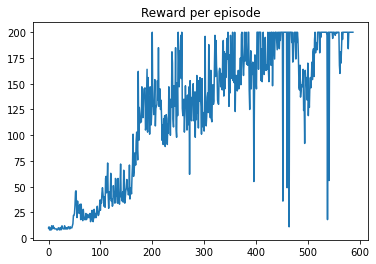

In [11]:
import matplotlib.pyplot as plt

plt.plot(agent.episode_reward_tracking)
plt.title("Reward per episode")
plt.show()

episode : 0
[ 0.9162409   0.51843595  0.02542824 -0.15809313] 1.0 True {'TimeLimit.truncated': True}
total reward 200.0
number of steps 200
average reward over last 20 runs 200.0
convergence attained, early exit
convergence attained with  20  episodes
average reward over last 20 runs 200.0


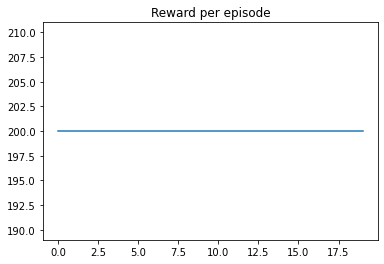

In [12]:
agent.num_ep = 200
agent.episode_reward_tracking = []

agent.run_episodes(train = 0)

plt.plot(agent.episode_reward_tracking)
plt.title("Reward per episode")
plt.show()